<a href="https://colab.research.google.com/github/Cozzalpha/Cozzalpha.github.io/blob/main/dc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crop Yield Prediction

In this model i have tested 3 model lr, random for, xgboost regressor. but xgboost regressor gave the highest accuracy

⭐ This installs fuzzywuzzy, a Python library for text matching and typo correction. It helps fix spelling errors in categorical data.

In [ ]:
!pip install fuzzywuzzy

# Loading the Dataset


Pandas is a powerful library used for handling tabular data (like Excel sheets and CSV files).

•	It provides tools to read, write, and manipulate datasets efficiently.

io (Input/Output module) is a built-in Python library that helps handle data streams (like files in memory instead of on disk).

•	It allows us to treat a file-like object as if it were an actual file on our computer.




In [ ]:
from google.colab import files
uploaded = files.upload()

Saving typo_crop_yield_dataset.csv to typo_crop_yield_dataset.csv


In [ ]:
import pandas as pd
import io
df1 = pd.read_csv(io.BytesIO(uploaded['typo_crop_yield_dataset.csv']))

In [ ]:
df1

,Nitrogen_Content,Phosphorus_Content,Potassium_Content,Soil_pH,Rainfall_mm,Avg_Temperature_C,Humidity_percent,Crop,Crop_Yield_ton_per_hectare,Irrigation Type,Soil Type
0,49.963210,25.745421,74.836898,6.998681,1513.996960,8.232979,67.860843,lentil,22.245078,drip,clay
1,96.057145,28.937426,69.949452,7.986987,532.121592,7.126381,54.446934,peanut,13.851263,drip,clay
2,78.559515,44.181896,51.138469,7.250667,823.951450,26.146718,92.337389,rice,15.313724,flood,sandy
3,67.892679,23.600175,102.872000,5.333210,1393.905146,38.814071,36.423384,whdat,20.626035,flood,silty
4,32.481491,44.785987,87.194899,5.742321,1067.760820,22.595246,64.089231,cotton,17.237157,drip,sandy
...,...,...,...,...,...,...,...,...,...,...,...
4995,NaN,44.306240,NaN,8.508155,789.476616,38.329641,52.580268,maize,17.452681,center pivot,sandy
4996,29.550481,45.900353,51.335801,5.187256,NaN,31.173847,54.768247,sugarcane,NaN,drip,peaty
4997,46.227427,47.868317,36.148745,6.214794,1861.893355,5.680955,59.725019,sugarcane,23.323958,center pivot,peaty
4998,85.259630,25.899520,NaN,6.773280,1347.114164,19.035169,NaN,soybean,21.727747,furrow,saline


# Data Cleaning

In [ ]:
import numpy as np  # 🔹 Used for numerical computations and handling arrays efficiently
import pandas as pd  # 🔹 Used for data manipulation and working with tabular data (DataFrames)

import matplotlib.pyplot as plt  # 🔹 Used for creating visualizations and plots
import seaborn as sns  # 🔹 Advanced data visualization library (built on top of matplotlib)

from sklearn.model_selection import train_test_split  # 🔹 Splits data into training & testing sets
from sklearn.preprocessing import StandardScaler  # 🔹 Scales numeric data to improve model performance

from sklearn.linear_model import LinearRegression  # 🔹 Implements a simple Linear Regression model
from xgboost import XGBRegressor  # 🔹 Implements the powerful XGBoost Regressor model

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# 🔹 Used to evaluate model performance using different error metrics:
#     - r2_score: Measures how well the model explains variance (closer to 1 is better)
#     - mean_absolute_error (MAE): Measures the average absolute difference between predictions and actual values
#     - mean_squared_error (MSE): Measures the squared difference between predictions and actual values



4️⃣ Fixing Typos in Categorical Data

👉 The dataset might contain spelling mistakes in crop names, soil types, and irrigation types. The code below corrects these typos.

✅ Defining Correct Categories


valid_crop_types = ["lentil", "peanut", "rice", "wheat", "cotton", "sugarcane", "soybean", "barley", "millet", "maize"]

valid_irrigation_types = ["drip", "flood", "furrow", "sprinkler", "center pivot"]

valid_soil_types = ["sandy", "silty", "loamy", "saline", "clay", "peaty"]


👉 These are the correct values for each column. Any incorrect value will be matched to the closest correct one.


🛠 Function to Fix Typos

from fuzzywuzzy import process

def correct_typo(value, valid_list):
    if pd.isna(value) or value.strip() == "":
        return value  # Keep NaNs (missing values)

    if value.isdigit():  
        return None  # Remove numerical values (invalid input)

    match, score = process.extractOne(value, valid_list)  # Find closest valid match
    return match if score > 75 else None  # Keep only high-confidence matches (score > 75)
👉 What this function does:

If value is missing (NaN) → Keep it.

If value is a number (e.g., 123) → Remove it.

Otherwise, use fuzzy string matching to correct the typo.

Example:

Incorrect Value	Corrected To

"wheet"	"wheat"

"peanutt"	"peanut"

"sprincler"	"sprinkler"

5️⃣ Applying Typo Correction to Dataset



df1["Crop"] = df1["Crop"].astype(str).apply(lambda x: correct_typo(x, valid_crop_types))
df1["Irrigation Type"] = df1["Irrigation Type"].astype(str).apply(lambda x: correct_typo(x, valid_irrigation_types))
df1["Soil Type"] = df1["Soil Type"].astype(str).apply(lambda x: correct_typo(x, valid_soil_types))

👉 This applies the typo correction function to each column.

6️⃣ Removing Invalid Rows

df1 = df1.dropna(subset=["Crop"])
👉 This removes rows where the "Crop" value could not be corrected (i.e., it was set to None).


7️⃣ Checking for Unexpected Crop Categories


unexpected_crops = set(df1["Crop"].unique()) - set(valid_crop_types)

if unexpected_crops:
    print("🚨 Unexpected Crop Categories:", unexpected_crops)

else:
    print("✅ All crop categories are valid.")
👉 This checks if any incorrect crop names still exist.


8️⃣ Save the Cleaned Dataset


df1.to_csv("corrected_crop_yield_dataset.csv", index=False)

print("✅ Corrected dataset saved as corrected_crop_yield_dataset.csv")

👉 The cleaned dataset is saved as a new CSV file (corrected_crop_yield_dataset.csv).

In [ ]:
"""import pandas as pd
from fuzzywuzzy import process

def clean_column(column, valid_values):
    cleaned_values = []
    for value in column:
        value = str(value)  # Ensure values are treated as strings
        if value in valid_values:
            cleaned_values.append(value)
        else:
            # Find the closest match from valid values
            best_match, score = process.extractOne(value, valid_values)
            cleaned_values.append(best_match if score > 80 else "Unknown")
    return cleaned_values  # Return as a list to maintain correct DataFrame assignment

# Data Cleaning after loading dataset
def clean_data(df1):
    valid_irrigation_types = ['Drip', 'Flood', 'Furrow', 'Sprinkler', 'Center Pivot']
    valid_crops = ['Lentil', 'Peanut', 'Rice', 'Wheat', 'Cotton', 'Sugarcane', 'Soybean', 'Barley', 'Millet', 'Maize']
    valid_soil_types = ['Sandy', 'Silty', 'Loamy', 'Saline', 'Clay', 'Peaty']  # Added soil types

    df1["Irrigation Type"] = pd.Series(clean_column(df1["Irrigation Type"], valid_irrigation_types), dtype='object')
    df1["Crop"] = pd.Series(clean_column(df1["Crop"], valid_crops), dtype='object')
    df1["Soil Type"] = pd.Series(clean_column(df1["Soil Type"], valid_soil_types), dtype='object')  # Added cleaning for soil type

    return df1

# Example usage (after loading dataset in IPYNB):
# df1 = clean_data(df1)
# display(df.head())
"""
"""
import pandas as pd
from fuzzywuzzy import process

# Step 1: Clean the Gibberish from Categorical Columns
categorical_cols = ["Crop", "Irrigation Type", "Soil Type"]

# Extract unique valid values from the dataset itself (pretending we only have this)
valid_crop_types = df1["Crop"].astype(str).str.lower().value_counts().index.tolist()
valid_irrigation_types = df1["Irrigation Type"].astype(str).str.lower().value_counts().index.tolist()
valid_soil_types = df1["Soil Type"].astype(str).str.lower().value_counts().index.tolist()

# Function to correct gibberish using fuzzy matching
def correct_value(value, valid_values, most_common):
    match, score = process.extractOne(value, valid_values)  # Find closest match
    return match if score > 80 else most_common  # If score is too low, replace with most common value

# Determine fallback replacements
most_common_crop = df1["Crop"].astype(str).str.lower().mode()[0]
most_common_irrigation = df1["Irrigation Type"].astype(str).str.lower().mode()[0]
most_common_soil = df1["Soil Type"].astype(str).str.lower().mode()[0]

# Apply fuzzy correction
df1["Crop"] = df1["Crop"].astype(str).str.lower().apply(lambda x: correct_value(x, valid_crop_types, most_common_crop))
df1["Irrigation Type"] = df1["Irrigation Type"].astype(str).str.lower().apply(lambda x: correct_value(x, valid_irrigation_types, most_common_irrigation))
df1["Soil Type"] = df1["Soil Type"].astype(str).str.lower().apply(lambda x: correct_value(x, valid_soil_types, most_common_soil))

print("\n✅ Categorical Data Cleaned!")

"""
"""
import pandas as pd
from fuzzywuzzy import process

# Load the dataset with typos
df = pd.read_csv("typo_crop_yield_dataset.csv")

# Define valid categories
valid_crop_types = ["lentil", "peanut", "rice", "wheat", "cotton", "sugarcane", "soybean", "barley", "millet", "maize"]
valid_irrigation_types = ["drip", "flood", "furrow", "sprinkler", "center pivot"]
valid_soil_types = ["sandy", "silty", "loamy", "saline", "clay", "peaty"]

# Function to fix typos by finding the closest valid match
def correct_typo(value, valid_list):
    if pd.isna(value) or value.strip() == "":
        return value  # Keep NaNs
    match, score = process.extractOne(value, valid_list)
    return match if score > 75 else value  # If confidence is high, replace it

# Apply corrections
df["Crop"] = df["Crop"].apply(lambda x: correct_typo(str(x), valid_crop_types))
df["Irrigation Type"] = df["Irrigation Type"].apply(lambda x: correct_typo(str(x), valid_irrigation_types))
df["Soil Type"] = df["Soil Type"].apply(lambda x: correct_typo(str(x), valid_soil_types))

# Save the corrected dataset
df.to_csv("corrected_crop_yield_dataset.csv", index=False)
print("✅ Corrected dataset saved as corrected_crop_yield_dataset.csv")
"""


import pandas as pd
from fuzzywuzzy import process

# Define valid categories
valid_crop_types = ["lentil", "peanut", "rice", "wheat", "cotton", "sugarcane", "soybean", "barley", "millet", "maize"]
valid_irrigation_types = ["drip", "flood", "furrow", "sprinkler", "center pivot"]
valid_soil_types = ["sandy", "silty", "loamy", "saline", "clay", "peaty"]

# Function to fix typos by finding the closest valid match
def correct_typo(value, valid_list):
    if pd.isna(value) or value.strip() == "":
        return value  # Keep NaNs

    # 🚨 Ensure the value is not a number (to prevent accidental encoding issues)
    if value.isdigit():
        return None  # Mark invalid numerical values for removal later

    match, score = process.extractOne(value, valid_list)
    return match if score > 75 else None  # Replace only if confidence is high; else mark for removal

# Apply corrections
df1["Crop"] = df1["Crop"].astype(str).apply(lambda x: correct_typo(x, valid_crop_types))
df1["Irrigation Type"] = df1["Irrigation Type"].astype(str).apply(lambda x: correct_typo(x, valid_irrigation_types))
df1["Soil Type"] = df1["Soil Type"].astype(str).apply(lambda x: correct_typo(x, valid_soil_types))

# 🚨 Remove rows with invalid crop names
df1 = df1.dropna(subset=["Crop"])

# Debugging: Print any unexpected crop categories
unexpected_crops = set(df1["Crop"].unique()) - set(valid_crop_types)
if unexpected_crops:
    print("🚨 Unexpected Crop Categories:", unexpected_crops)
else:
    print("✅ All crop categories are valid.")

# Save the corrected dataset
df1.to_csv("corrected_crop_yield_dataset.csv", index=False)
print("✅ Corrected dataset saved as corrected_crop_yield_dataset.csv")



✅ All crop categories are valid.
✅ Corrected dataset saved as corrected_crop_yield_dataset.csv


In [ ]:
from google.colab import files
files.download('corrected_crop_yield_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#df1 = pd.read_csv("corrected_crop_yield_dataset.csv")
df1

,Nitrogen_Content,Phosphorus_Content,Potassium_Content,Soil_pH,Rainfall_mm,Avg_Temperature_C,Humidity_percent,Crop,Crop_Yield_ton_per_hectare,Irrigation Type,Soil Type
0,49.963210,25.745421,74.836898,6.998681,1513.996960,8.232979,67.860843,lentil,22.245078,drip,clay
1,96.057145,28.937426,69.949452,7.986987,532.121592,7.126381,54.446934,peanut,13.851263,drip,clay
2,78.559515,44.181896,51.138469,7.250667,823.951450,26.146718,92.337389,rice,15.313724,flood,sandy
3,67.892679,23.600175,102.872000,5.333210,1393.905146,38.814071,36.423384,wheat,20.626035,flood,silty
4,32.481491,44.785987,87.194899,5.742321,1067.760820,22.595246,64.089231,cotton,17.237157,drip,sandy
...,...,...,...,...,...,...,...,...,...,...,...
4995,NaN,44.306240,NaN,8.508155,789.476616,38.329641,52.580268,maize,17.452681,center pivot,sandy
4996,29.550481,45.900353,51.335801,5.187256,NaN,31.173847,54.768247,sugarcane,NaN,drip,peaty
4997,46.227427,47.868317,36.148745,6.214794,1861.893355,5.680955,59.725019,sugarcane,23.323958,center pivot,peaty
4998,85.259630,25.899520,NaN,6.773280,1347.114164,19.035169,NaN,soybean,21.727747,furrow,saline


Some processing to check the categories set


In [ ]:
"""valid_crop_types = {"lentil", "peanut", "rice", "wheat", "cotton", "sugarcane", "soybean", "barley", "millet", "maize"}
dataset_crops = set(df1["Crop"].unique())

# Find extra/unexpected crops
unexpected_crops = dataset_crops - valid_crop_types
print("Unexpected Crop Categories:", unexpected_crops)
"""

Unexpected Crop Categories: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)}


In [ ]:
#print(df1["Crop"].dtype)


object


In [ ]:
#for crop in df1["Crop"].unique():
#    print(repr(crop), type(crop))


'8' <class 'str'>
'16' <class 'str'>
'1' <class 'str'>
'15' <class 'str'>
'14' <class 'str'>
'0' <class 'str'>
'5' <class 'str'>
'4' <class 'str'>
'6' <class 'str'>
'3' <class 'str'>
'17' <class 'str'>
'13' <class 'str'>
'11' <class 'str'>
'2' <class 'str'>
'7' <class 'str'>
'10' <class 'str'>
'9' <class 'str'>


In [ ]:
"""crop_mapping = {
    "0": "lentil", "1": "peanut", "2": "rice", "3": "wheat",
    "4": "cotton", "5": "sugarcane", "6": "soybean", "7": "barley",
    "8": "millet", "9": "maize", "10": "sorghum", "11": "cassava",
    "12": "coffee", "13": "tea", "14": "banana", "15": "grapes",
    "16": "tomato", "17": "potato"
}
df1["Crop"] = df1["Crop"].map(crop_mapping)
"""

<ipython-input-30-7dd83fc70efb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Crop"] = df1["Crop"].map(crop_mapping)


In [ ]:
#print(df1["Crop"].unique())

['millet' 'tomato' 'peanut' 'grapes' 'banana' 'lentil' 'sugarcane'
 'cotton' 'soybean' 'wheat' 'potato' 'tea' 'cassava' 'rice' 'barley'
 'sorghum' 'maize']


End of Processing

⭐ Step-by-Step Explanation:

 1)Calculate the First Quartile (Q1):


Q1 = df1.quantile(0.25)

This finds the 25th percentile (lower quartile) for each column in df1.


2) Calculate the Third Quartile (Q3):

Q3 = df1.quantile(0.75)

This finds the 75th percentile (upper quartile) for each column.


3)Compute the Interquartile Range (IQR):

IQR = Q3 - Q1

The IQR measures the spread of the middle 50% of the data.

4)Identify Outliers:


df1 < (Q1 - 1.5 * IQR) | (df1 > (Q3 + 1.5 * IQR))

5) Outliers are defined as values that fall below

Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

6) Remove Rows Containing Any Outliers:


df1 = df1[~((df1 < (Q1 - 1.5 * IQR)) | (df1 > (Q3 + 1.5 * IQR))).any(axis=1)]

The any(axis=1) function ensures that if any column in a row has an outlier, the entire row is removed.


The ~ (tilde) negates the condition to keep only non-outlier rows.

Final Outcome
This approach ensures that all rows containing at least one outlier are removed from df1, leaving only the "clean" data points.


<ipython-input-105-1252aa991c0d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = le.fit_transform(df1[col].astype(str))  # Convert to string before encoding
<ipython-input-105-1252aa991c0d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = le.fit_transform(df1[col].astype(str))  # Convert to string before encoding
<ipython-input-105-1252aa991c0d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu


🔍 Initial Missing Values:
Nitrogen_Content              0
Phosphorus_Content            0
Potassium_Content             0
Soil_pH                       0
Rainfall_mm                   0
Avg_Temperature_C             0
Humidity_percent              0
Crop                          0
Crop_Yield_ton_per_hectare    0
Irrigation Type               0
Soil Type                     0
dtype: int64

✅ Data After Cleaning: (4890, 11)


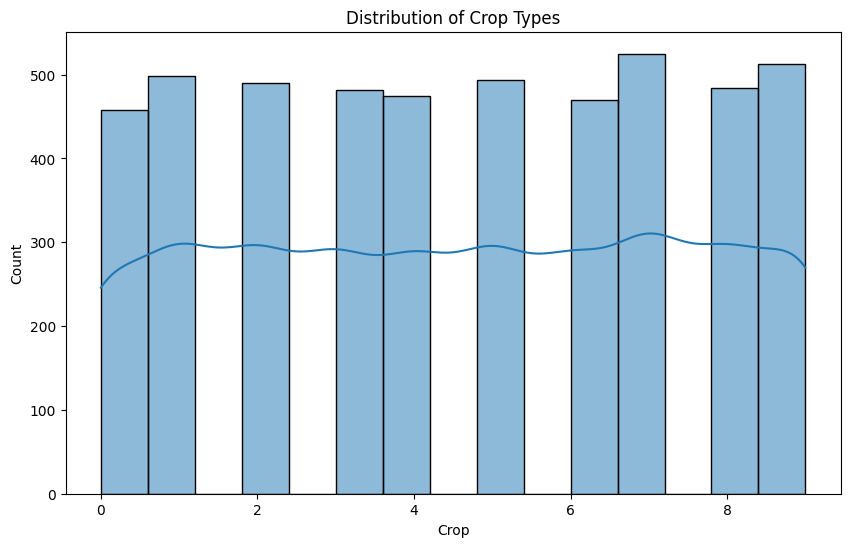

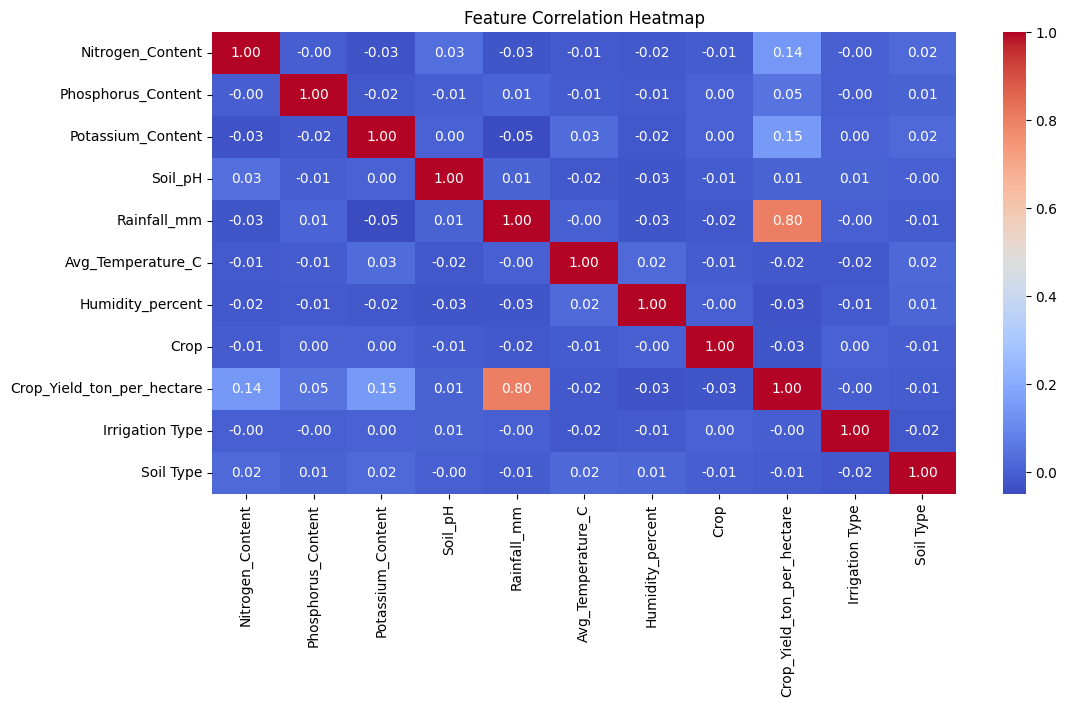

In [ ]:
# Step 1: Data Cleaning

# Convert categorical columns using Label Encoding
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["Crop", "Irrigation Type", "Soil Type"]
for col in categorical_cols:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col].astype(str))  # Convert to string before encoding

df1

print("\n🔍 Initial Missing Values:")
print(df1.isnull().sum())

# Fill missing values with median for numerical columns
df1.fillna(df1.median(), inplace=True)

# Detect and remove outliers using IQR method ---  Removing outliers improves model stability, statistical accuracy, and prediction reliability while preventing biases.
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1
df1 = df1[~((df1 < (Q1 - 1.5 * IQR)) | (df1 > (Q3 + 1.5 * IQR))).any(axis=1)]

print("\n✅ Data After Cleaning:", df1.shape)

# Step 2: Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.histplot(df1["Crop"], bins=15, kde=True)
plt.title("Distribution of Crop Types")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(df1.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
num_crops = df1["Crop"].nunique()
num_soil_types = df1["Soil Type"].nunique()
num_irrigation_types = df1["Irrigation Type"].nunique()

print(f"Total Crop Categories: {num_crops}")
print(f"Total Soil Type Categories: {num_soil_types}")
print(f"Total Irrigation Type Categories: {num_irrigation_types}")


Total Crop Categories: 10
Total Soil Type Categories: 7
Total Irrigation Type Categories: 6


In [ ]:
print("Unique Crop Types:", df1["Crop"].unique())
print("Unique Soil Types:", df1["Soil Type"].unique())
print("Unique Irrigation Types:", df1["Irrigation Type"].unique())


Unique Crop Types: [2 5 6 9 1 8 7 0 4 3]
Unique Soil Types: [1 5 6 4 3 2 0]
Unique Irrigation Types: [2 3 4 5 1 0]


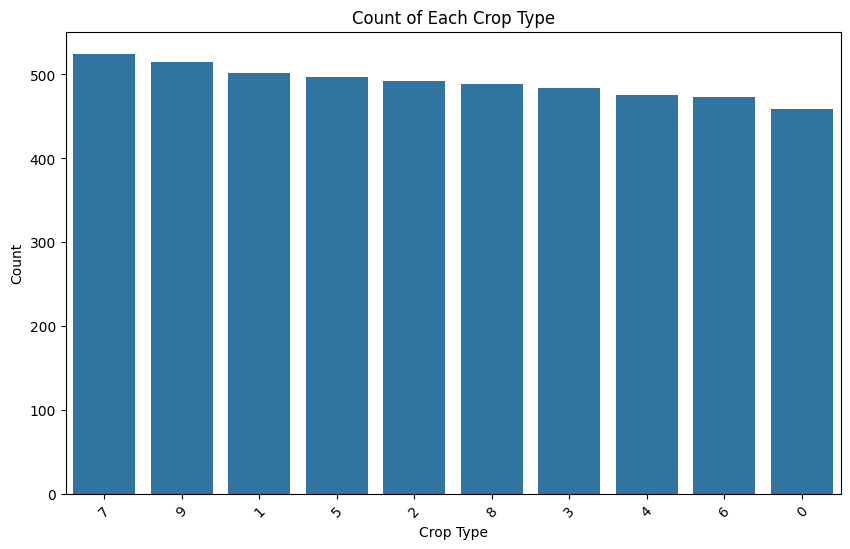

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df1["Crop"], order=df1["Crop"].value_counts().index)
plt.xticks(rotation=45)  # Rotate labels for readability
plt.title("Count of Each Crop Type")
plt.xlabel("Crop Type")
plt.ylabel("Count")
plt.show()


In [ ]:
df1

,Nitrogen_Content,Phosphorus_Content,Potassium_Content,Soil_pH,Rainfall_mm,Avg_Temperature_C,Humidity_percent,Crop,Crop_Yield_ton_per_hectare,Irrigation Type,Soil Type
0,49.963210,25.745421,74.836898,6.998681,1513.996960,8.232979,67.860843,2,22.245078,2,1
1,96.057145,28.937426,69.949452,7.986987,532.121592,7.126381,54.446934,5,13.851263,2,1
2,78.559515,44.181896,51.138469,7.250667,823.951450,26.146718,92.337389,6,15.313724,3,5
3,67.892679,23.600175,102.872000,5.333210,1393.905146,38.814071,36.423384,9,20.626035,3,6
4,32.481491,44.785987,87.194899,5.742321,1067.760820,22.595246,64.089231,1,17.237157,2,5
...,...,...,...,...,...,...,...,...,...,...,...
4995,60.314929,44.306240,89.290116,8.508155,789.476616,38.329641,52.580268,3,17.452681,1,5
4996,29.550481,45.900353,51.335801,5.187256,1121.416266,31.173847,54.768247,8,18.261718,2,3
4997,46.227427,47.868317,36.148745,6.214794,1861.893355,5.680955,59.725019,8,23.323958,1,3
4998,85.259630,25.899520,89.290116,6.773280,1347.114164,19.035169,57.701499,7,21.727747,4,4


In [ ]:
import plotly.express as px  # For creating interactive and visually appealing plots

import matplotlib  # Core Matplotlib library for data visualization

import matplotlib.pyplot as plt  # Submodule of Matplotlib, used for plotting static graphs

import seaborn as sns  # Statistical data visualization library built on Matplotlib

%matplotlib inline  # Ensures plots are displayed directly in Jupyter Notebook


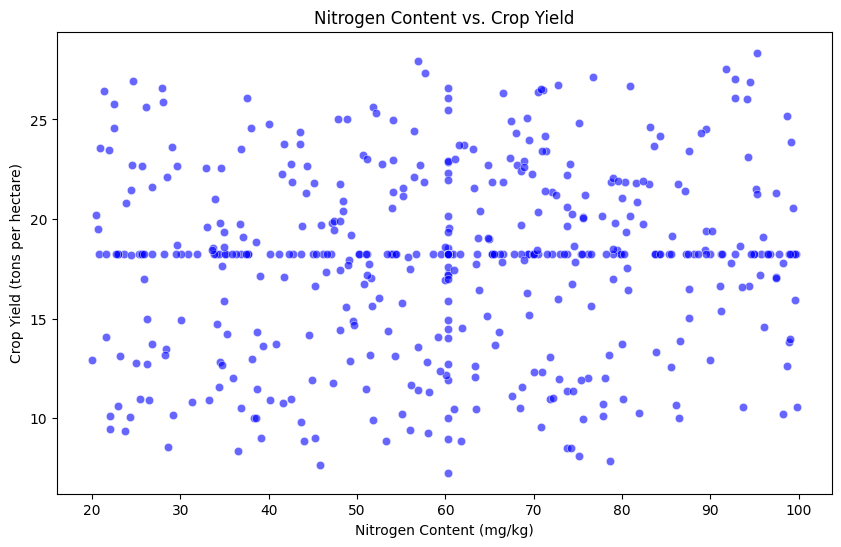

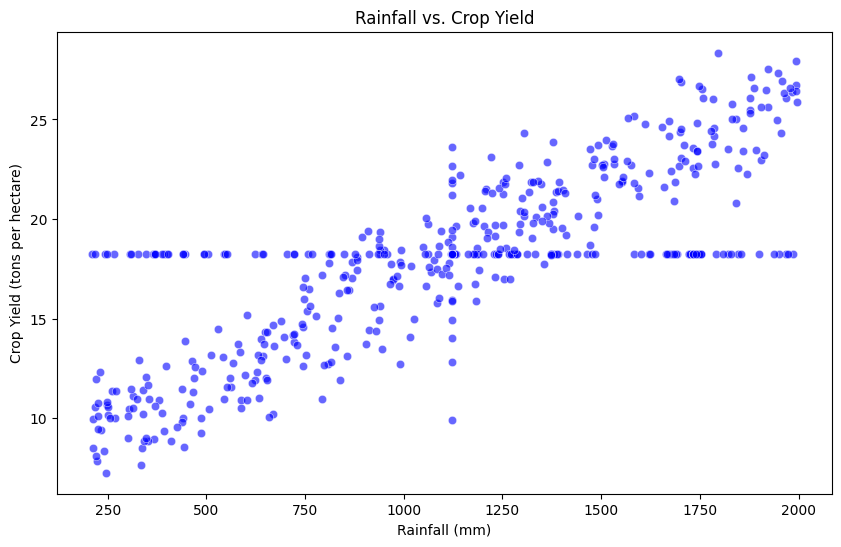

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data to show fewer points
df_sampled = df1.sample(frac=0.1, random_state=42)

# Scatter Plot: Nitrogen Content vs Crop Yield
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sampled, x="Nitrogen_Content", y="Crop_Yield_ton_per_hectare", color="blue", alpha=0.6)
plt.title("Nitrogen Content vs. Crop Yield")
plt.xlabel("Nitrogen Content (mg/kg)")
plt.ylabel("Crop Yield (tons per hectare)")
plt.show()

# Scatter Plot: Rainfall vs Crop Yield
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sampled, x="Rainfall_mm", y="Crop_Yield_ton_per_hectare", color="blue", alpha=0.6)
plt.title("Rainfall vs. Crop Yield")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Crop Yield (tons per hectare)")
plt.show()


# Splitting the Dataset into Train, Test and Validation

What is Linear Regression?
Linear Regression is a supervised machine learning algorithm used to predict a continuous dependent variable (output) based on one or more independent variables (inputs). The goal is to find the best-fit line that minimizes the error between the predicted values and actual values.

Mathematical Representation of Simple Linear Regression

Simple Linear Regression (with one independent variable
𝑥

x) follows the equation:

𝑦
=
𝑚
𝑥
+
𝑏
y=mx+b

Where:

𝑦
y = Predicted output (dependent variable)

𝑥
x = Input feature (independent variable)

𝑚
m = Slope of the line (weight or coefficient)

𝑏
b = Intercept (bias term)

The slope
𝑚
m determines how much
𝑦
y changes when
𝑥
x increases by one unit.

Example
If the equation is:

𝑦
=
2
𝑥
+
3
y=2x+3

When
𝑥
=
1
x=1, then
𝑦
=
2
(
1
)
+
3
=
5
y=2(1)+3=5.

When
𝑥
=
2
x=2, then
𝑦
=
2
(
2
)
+
3
=
7
y=2(2)+3=7.

Mathematical Representation of Multiple Linear Regression

When we have multiple independent variables (
𝑥
1
,
𝑥
2
,
𝑥
3
,
…
,
𝑥
𝑛
x
1
​
 ,x
2
​
 ,x
3
​
 ,…,x
n
​
 ), the equation extends to:

𝑦
=
𝑤
1
𝑥
1
+
𝑤
2
𝑥
2
+
⋯
+
𝑤
𝑛
𝑥
𝑛
+
𝑏

y=w
1
​
 x
1
​
 +w
2
​
 x
2
​
 +⋯+w
n
​
 x
n
​
 +b

In vector notation, this is written as:

𝑦
=
𝑋
𝑤
+
𝑏

y=Xw+b

Where:

𝑋
X = Matrix of input features (size:
𝑚
×
𝑛
m×n)

𝑤
w = Vector of weights (size:
𝑛
×
1
n×1)

𝑏
b = Bias term

𝑦
y = Output vector (size:
𝑚
×
1
m×1)

This is the equation of a hyperplane instead of a straight line.



In [ ]:

# Step 3: Train-Validation-Test Split
X = df1.drop("Crop_Yield_ton_per_hectare", axis=1)        #This removes the target variable (Crop_Yield_ton_per_hectare) from the dataset, keeping only the input features.
y = df1["Crop_Yield_ton_per_hectare"]                     #This selects the target variable (Crop_Yield_ton_per_hectare) for prediction.

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  #This splits the dataset into a training set (70%) and a temporary set (30%) for further splitting.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)   #This splits the temporary set into validation (15%) and test sets (15%).



In [ ]:
# Normalize data
scaler = StandardScaler()  #This initializes the StandardScaler, which standardizes features by removing the mean and scaling to unit variance.


X_train = scaler.fit_transform(X_train)   #This fits the scaler on the training data and transforms it
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [ ]:
import pandas as pd

# Feature Importance from XGBoost
feature_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)    #This extracts feature importance scores from an XGBoost model.


print("\nTop Important Features:\n", feature_importance.sort_values(ascending=False))   #This prints the features sorted by importance in descending order.

# Drop features with very low importance (e.g., < 0.01)
low_importance_features = feature_importance[feature_importance < 0.01].index     #This identifies features with very low importance (less than 0.01).

X_train = pd.DataFrame(X_train, columns=X.columns).drop(columns=low_importance_features)
X_val = pd.DataFrame(X_val, columns=X.columns).drop(columns=low_importance_features)
X_test = pd.DataFrame(X_test, columns=X.columns).drop(columns=low_importance_features)



Top Important Features:
 Rainfall_mm           0.612316
Potassium_Content     0.089246
Nitrogen_Content      0.063047
Phosphorus_Content    0.049816
Avg_Temperature_C     0.047095
Humidity_percent      0.032542
Soil_pH               0.028296
Irrigation Type       0.027464
Soil Type             0.026910
Crop                  0.023268
dtype: float32


In [ ]:
# Step 4: Baseline Model - Linear Regression
lr_model = LinearRegression()     #initializes
lr_model.fit(X_train, y_train)    # trains the model using the training dataset.


LinearRegression()

In [ ]:
y_train_pred = lr_model.predict(X_train)     #makes predictions on the training set.
y_val_pred = lr_model.predict(X_val)
y_test_pred = lr_model.predict(X_test)

In [ ]:
print("Linear Regression Performance:")
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")      #R² score, which measures how well the model explains the variance in the training data.
print(f"Validation R²: {r2_score(y_val, y_val_pred):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")

Linear Regression Performance:
Train R²: 0.7147
Validation R²: 0.6807
Test R²: 0.7028


XGBoost

In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5,
                         subsample=0.8, colsample_bytree=1.0, random_state=42)



In [ ]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predictions on Train, Validation, and Test Sets
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

In [ ]:
# Evaluate Model Performance
print("\n🚀 XGBoost Model Performance:")
print(f"Train R²: {r2_score(y_train, y_train_pred_xgb):.4f}")
print(f"Validation R²: {r2_score(y_val, y_val_pred_xgb):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred_xgb):.4f}")



🚀 XGBoost Model Performance:
Train R²: 0.9135
Validation R²: 0.7103
Test R²: 0.7244
Train MAE: 0.9448
Validation MAE: 1.7005
Test MAE: 1.6502
Train RMSE: 1.3423
Validation RMSE: 2.4707
Test RMSE: 2.4430


yeah


# Final Testing

In [ ]:
import pickle
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns and save the encoders
categorical_cols = ["Crop", "Irrigation Type", "Soil Type"]
encoders = {}  # Dictionary to store encoders

for col in categorical_cols:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col].astype(str))  # Convert to string before encoding
    encoders[col] = le  # Save encoder

# Save encoders for later use
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)


<ipython-input-106-c9eda4522b77>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = le.fit_transform(df1[col].astype(str))  # Convert to string before encoding
<ipython-input-106-c9eda4522b77>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = le.fit_transform(df1[col].astype(str))  # Convert to string before encoding
<ipython-input-106-c9eda4522b77>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [ ]:
import pickle
import pandas as pd

# Load the saved encoders
with open("label_encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

# Create sample input data
sample_input = pd.DataFrame({
    "Nitrogen_Content": [49.96],
    "Phosphorus_Content": [25.74],
    "Potassium_Content": [74.83],
    "Soil_pH": [6.99],
    "Rainfall_mm": [1513.99],
    "Avg_Temperature_C": [8.23],
    "Humidity_percent": [67.86],
    "Crop": ["wheat"],  # 🚨 "wheat" was not in training!
    "Irrigation Type": ["drip"],
    "Soil Type": ["clay"]
})

# Apply the same encoding as used in training
for col in ["Crop", "Irrigation Type", "Soil Type"]:
    known_classes = encoders[col].classes_

    # Check if all values exist in known classes, else assign -1 for unknown values
    sample_input[col] = sample_input[col].apply(lambda x: encoders[col].transform([x])[0] if x in known_classes else -1)

# Make prediction
predicted_yield = xgb_model.predict(sample_input)

print(f"Predicted Crop Yield (tons per hectare): {predicted_yield[0]:.4f}")


Predicted Crop Yield (tons per hectare): 20.4745


# Rough Work

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)  #This initializes a Random Forest model with 200 trees and a max depth of 10.

rf_model.fit(X_train, y_train)  #This trains the model on the training dataset.

# Predictions
y_train_pred_rf = rf_model.predict(X_train)  #makes predictions on the training data.
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest Model
print("\n🌳 Random Forest Model Performance:")
print(f"Train R²: {r2_score(y_train, y_train_pred_rf):.4f}")
print(f"Validation R²: {r2_score(y_val, y_val_pred_rf):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred_rf):.4f}")



🌳 Random Forest Model Performance:
Train R²: 0.9235
Validation R²: 0.6898
Test R²: 0.7163
Train MAE: 0.9126
Validation MAE: 1.8068
Test MAE: 1.7217
Train RMSE: 1.2620
Validation RMSE: 2.5564
Test RMSE: 2.4784


In [ ]:
xgb_model = XGBRegressor(n_estimators=80, learning_rate=0.05, max_depth=5,
                         subsample=0.8, colsample_bytree=1.0, random_state=42)

xgb_model.fit(X_train, y_train)

# Predictions on Train, Validation, and Test Sets
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate Model Performance
print("\n🚀 XGBoost Model Performance:")
print(f"Train R²: {r2_score(y_train, y_train_pred_xgb):.4f}")
print(f"Validation R²: {r2_score(y_val, y_val_pred_xgb):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred_xgb):.4f}")

print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred_xgb):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred_xgb):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred_xgb):.4f}")

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred_xgb)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)):.4f}")


🚀 XGBoost Model Performance:
Train R²: 0.8368
Validation R²: 0.7140
Test R²: 0.7372
Train MAE: 1.3250
Validation MAE: 1.7438
Test MAE: 1.6522
Train RMSE: 1.8438
Validation RMSE: 2.4547
Test RMSE: 2.3857


In [ ]:
# Blended Model (Averaging Predictions)
y_train_pred_avg = (y_train_pred + y_train_pred_rf + y_train_pred_xgb) / 3
y_val_pred_avg = (y_val_pred + y_val_pred_rf + y_val_pred_xgb) / 3
y_test_pred_avg = (y_test_pred + y_test_pred_rf + y_test_pred_xgb) / 3

print("\n📊 Blended Model Performance:")
print(f"Train R²: {r2_score(y_train, y_train_pred_avg):.4f}")
print(f"Validation R²: {r2_score(y_val, y_val_pred_avg):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred_avg):.4f}")



📊 Blended Model Performance:
Train R²: 0.8630
Validation R²: 0.7065
Test R²: 0.7263


In [ ]:
# Stacked Model (Using a Meta Model)
import numpy as np
from sklearn.linear_model import LinearRegression

stacked_features_train = np.column_stack((y_train_pred, y_train_pred_rf, y_train_pred_xgb))
stacked_features_val = np.column_stack((y_val_pred, y_val_pred_rf, y_val_pred_xgb))
stacked_features_test = np.column_stack((y_test_pred, y_test_pred_rf, y_test_pred_xgb))

meta_model = LinearRegression()
meta_model.fit(stacked_features_train, y_train)

y_train_pred_meta = meta_model.predict(stacked_features_train)
y_val_pred_meta = meta_model.predict(stacked_features_val)
y_test_pred_meta = meta_model.predict(stacked_features_test)

print("\n🔗 Stacked Model Performance:")
print(f"Train R²: {r2_score(y_train, y_train_pred_meta):.4f}")
print(f"Validation R²: {r2_score(y_val, y_val_pred_meta):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred_meta):.4f}")



🔗 Stacked Model Performance:
Train R²: 0.9581
Validation R²: 0.6456
Test R²: 0.6841


In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1️⃣ Load Data (Assuming df1 is already preprocessed)
X = df1.drop("Crop_Yield_ton_per_hectare", axis=1)
y = df1["Crop_Yield_ton_per_hectare"]

# 2️⃣ Train-Validation-Test Split (70% Train, 15% Validation, 15% Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3️⃣ Train XGBoost Model
xgb_model = XGBRegressor(
    n_estimators=80,         # Number of boosting rounds
    learning_rate=0.05,      # Step size shrinkage
    max_depth=5,             # Tree depth
    subsample=0.8,           # Fraction of samples per tree
    colsample_bytree=1.0,    # Fraction of features per tree
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 4️⃣ Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

# 5️⃣ Model Evaluation
print("\n🚀 XGBoost Model Performance:")
print(f"Train R²: {r2_score(y_train, y_train_pred_xgb):.4f}")
print(f"Validation R²: {r2_score(y_val, y_val_pred_xgb):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred_xgb):.4f}")

print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred_xgb):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred_xgb):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred_xgb):.4f}")

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred_xgb)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)):.4f}")

# 6️⃣ Feature Importance
feature_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
print("\n🌟 Top Important Features:\n", feature_importance.sort_values(ascending=False))

# Drop low-importance features (Optional)
low_importance_features = feature_importance[feature_importance < 0.01].index
X_train = X_train.drop(columns=low_importance_features)
X_val = X_val.drop(columns=low_importance_features)
X_test = X_test.drop(columns=low_importance_features)



🚀 XGBoost Model Performance:
Train R²: 0.8368
Validation R²: 0.7140
Test R²: 0.7372
Train MAE: 1.3250
Validation MAE: 1.7438
Test MAE: 1.6522
Train RMSE: 1.8438
Validation RMSE: 2.4547
Test RMSE: 2.3857

🌟 Top Important Features:
 Rainfall_mm           0.645210
Potassium_Content     0.072815
Nitrogen_Content      0.058392
Phosphorus_Content    0.046106
Avg_Temperature_C     0.043247
Humidity_percent      0.032120
Irrigation Type       0.028330
Soil_pH               0.027173
Soil Type             0.025024
Crop                  0.021583
dtype: float32
